# 0. Introduction

You're currently using the Internet to read this and you're very thankful for that, but what about those people that do not have regular access to food or medical care? Here we have a dataset which tell us how many people in poverty situation have access to the internet in their homes in the United States. The original data can be found here: https://www.kaggle.com/mmattson/us-broadband-availability. We won't be using the `source_sets` folder.

We want to know which circumstance is the most stopping for people from having Internet access at home, and which state is the most precarious in that matter. We'll predict, given some stadistics, the probability for that county to have internet access at home or not.

For that, we'll follow these three steps:

* We'll decide which are the most useful attributes and which one we will process.
* We'll briefly describe the computational method applied along with the chosen parameters (!)
* And we'll expose our results.

First of all we'll need to import some libraries:
* Using *numpy* and *pandas* we'll treat our data.
* With *skicit-learn* we'll train and test our models.
* *matplotlib* and *seaborn* will help us with our graphics.
* With *math* we'll evaluate our models.

In [1]:
#first things first
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as skl_ms
import sklearn.linear_model as skl_lm
import sklearn.tree as skl_tree
import sklearn.metrics as skl_metrics
import sklearn.ensemble as skl_ensemble
import math

# 1. Data cleaning and preparation

First of all, we read it:

In [2]:
#loading
pd.set_option('display.max_columns', None)
df = pd.read_csv('../../data/broadband_access.csv')
print("We have", df.shape[0], "entries.")
print("We have", df.shape[1], "attributes.")
print(df.head())

We have 3142 entries.
We have 23 attributes.
                 full_name   county    state state_abr  population  unemp  \
0  Autauga County, Alabama  Autauga  Alabama        AL     55869.0    2.7   
1  Baldwin County, Alabama  Baldwin  Alabama        AL    223234.0    2.7   
2  Barbour County, Alabama  Barbour  Alabama        AL     24686.0    3.8   
3     Bibb County, Alabama     Bibb  Alabama        AL     22394.0    3.1   
4   Blount County, Alabama   Blount  Alabama        AL     57826.0    2.7   

   health_ins  poverty  SNAP  no_comp  no_internet  home_broad  broad_num  \
0         7.1     15.4  12.7     13.0         20.9        78.9        0.0   
1        10.2     10.6   7.5     11.4         21.3        78.1        0.0   
2        11.2     28.9  27.4     23.9         38.9        60.4        4.0   
3         7.9     14.0  12.4     23.7         33.8        66.1        0.0   
4        11.0     14.4   9.5     21.3         30.6        68.5        0.0   

   broad_avail  broad_cost  p

We have info for every county in the United States, which gives us 3142 tuples. We have several attributes related to their population statistics, including some about broadband availability and their providers. These are:
* Discrete, string variables related to county name (`county`), state name (`state`) and its abbreviation (`state_abr`), and a combination of both county and state name (`full_name`).
* Two discrete variables showing population: `population` and `population_bbn`.
* Rates for each county regarding unemployment (`unemp`), no health insurance (`health_ins`), poverty (`poverty`), people who received Supplemental Nutrition Assistance Program (`SNAP`), no computer at home (`no_comp`), no internet at home (`no_internet`) and percent with home broadband (`home_broad`). All of them are continuous since their values are between a 0-100 range (they're percentile).
* We have the number of providers available per county (`broad_num`), population for whom broadband is available (`broad_avail`) and its lowest cost per month (`broad_cast`). Here we're starting to see some NaN values that depend of another variable. Another attribute tells us the lowest broadband cost per month too (`price_bbn`), since we have data from two different sets.
* Some other numerical attributes with a `_bbn` suffix contain the number of Wired connection providers (like cable or fiber) (`wired_bbn`), number of providers of any technology (`provide_bbn`), number of those who offer high speed connections (`all25_bbn`), the average download speed (`downave_bbn`), percent of population that has access to terrestrial (wired + wireless) broadband (`access_bbn`) and fraction of people who was slow speed connection (`slowfrac_bbn`).

Some attributes look unnecessary and redundant, like `price_bbn` and `broad_cost`, and some are related to download speed. Do we really need them if we only need to understand why people can't have them at home? Do we need to normalize since one attribute has 0-1 values and others are percentile (0-100)? We'll do the latter right now before continuing.

In [3]:
df["slowfrac_bbn"] = [element * 100 for element in df["slowfrac_bbn"]]
print(df["slowfrac_bbn"].head())

0     16.375161
1     69.129038
2     13.417445
3     49.989288
4    100.000000
Name: slowfrac_bbn, dtype: float64


Now we'll check those NaN values and object variables, so they don't interfere with the model we'll construct or other future calculations.

In [4]:
df.info()
nulls = df.isnull().sum()
print(nulls[nulls>0])
print("How many attributes with at least one null do we have?", nulls[nulls>0].shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   full_name       3142 non-null   object 
 1   county          3142 non-null   object 
 2   state           3142 non-null   object 
 3   state_abr       3142 non-null   object 
 4   population      3142 non-null   float64
 5   unemp           3141 non-null   float64
 6   health_ins      3142 non-null   float64
 7   poverty         3141 non-null   float64
 8   SNAP            3142 non-null   float64
 9   no_comp         3142 non-null   float64
 10  no_internet     3142 non-null   float64
 11  home_broad      3142 non-null   float64
 12  broad_num       3141 non-null   float64
 13  broad_avail     3141 non-null   float64
 14  broad_cost      3102 non-null   float64
 15  population_bbn  3128 non-null   float64
 16  price_bbn       3031 non-null   float64
 17  wired_bbn       3128 non-null   f

As we can see, some attributes have null values, the worst being `price_bbn`. This is because this variable depends on another; if `broad_avail` equals 0, `broad_cost` and `price_bbn` will be null; since there is no broadband availability in that country so there's not going to be a price for it (although, for some reason, the former shows prices even with null availability values). We'll have to fill those with zeros then. All other tuples with null values will be dropped (there are few nulls so it's no big deal).

Like we said before, some of them may seem useless for what we're trying to predict, but we won't remove them.

Later, we'll drop those "object" variables, so they don't mess with the model we'll construct.

In [5]:
df["broad_cost"].fillna(0)
df["price_bbn"].fillna(0)

df = df.dropna()
df = df.loc[:, (df.dtypes != 'object')]

nulls = df.isnull().sum()

print("We have", df.shape[0], "entries now.")
print("How many attributes with at least one null do we have?", nulls[nulls>0].shape[0])

We have 3000 entries now.
How many attributes with at least one null do we have? 0


Now we have no objects and no nulls.

# 2. Data exploration

Now it's time to understand more our target attribute, `no_internet`.

<Figure size 720x720 with 0 Axes>

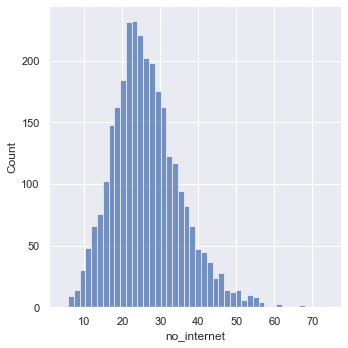

In [6]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,10))
sns.displot(df['no_internet'])
plt.show()

As we can see, we almost have a Gaussian distribution where most values appear to be between 20(%) and 30(%).

Which attributes appear to correlate the most with our target value?

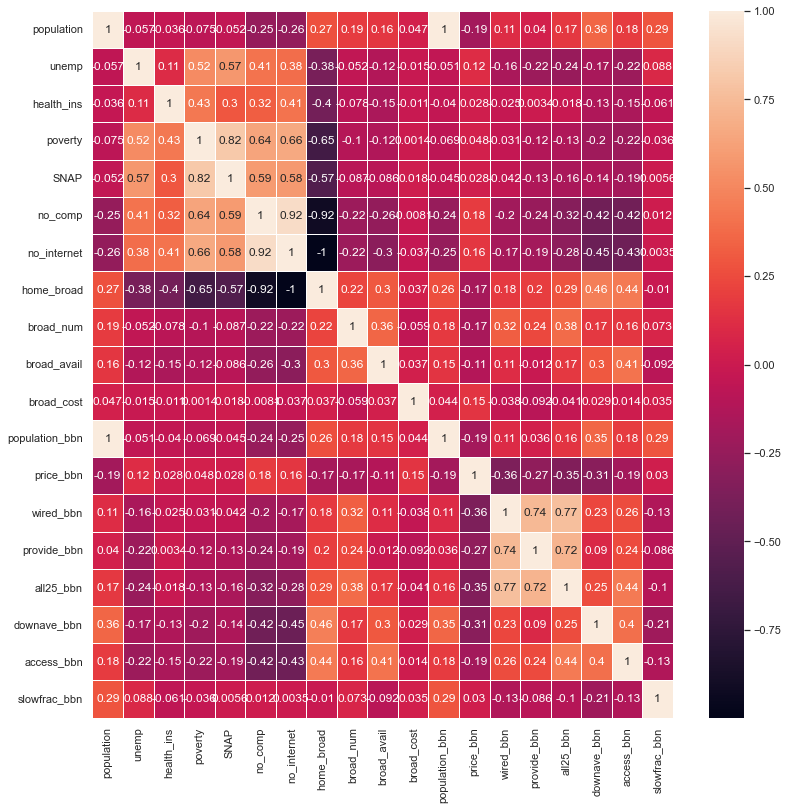

In [7]:
correlacio = df.corr()
plt.figure(figsize=(13,13))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

At first sight, we see, for example, that `population` and `population_bbn` are duplicates, and `no_internet` contains the inverse data of `home_broad` (broadband at home).

Other values that have strong correlation include `no_comp` with `no_internet`, `poverty` with `SNAP`, `wired_bbn` with `provide_bbn`, and `all25_bbn` with `provide_bbn`.

Correlated to our target attribute, we have:

no_internet       1.000000
no_comp           0.917601
poverty           0.660065
SNAP              0.579629
health_ins        0.411293
unemp             0.384866
price_bbn         0.164265
slowfrac_bbn      0.003532
broad_cost       -0.037438
wired_bbn        -0.172366
provide_bbn      -0.191831
broad_num        -0.220888
population_bbn   -0.252479
population       -0.261237
all25_bbn        -0.283476
broad_avail      -0.298658
access_bbn       -0.431606
downave_bbn      -0.449781
home_broad       -0.998015
Name: no_internet, dtype: float64


<AxesSubplot:>

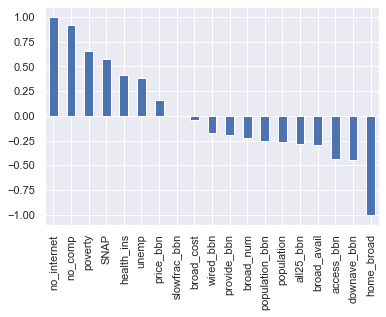

In [8]:
corr = df.corr()['no_internet'].sort_values(ascending=False)
print(corr)
corr.plot(kind='bar')

We'll establish a threshold of 0.2, so we're going to use the following to know about them better and how do they interfere in no having internet at home: `no_comp`, `poverty`, `SNAP`, `health_ins` and `unemp`.

First we'll discuss `no_comp`.

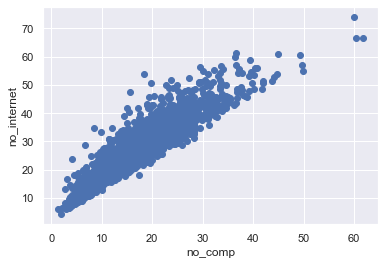

In [9]:
plt.scatter(df["no_comp"], df["no_internet"])
plt.xlabel("no_comp")
plt.ylabel("no_internet")
plt.show()

As we can see, if we have no computer at home, we won't have internet either. Both variables are strongly correlated.

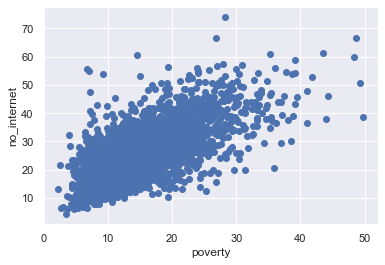

In [10]:
plt.scatter(df["poverty"], df["no_internet"])
plt.xlabel("poverty")
plt.ylabel("no_internet")
plt.show()

Here we see that regions where poverty rate is around 10% or 20% doesn't necessarily mean that they won't have internet at home, as we see many cases where this is happening. This doesn't tend to happen when poverty rate is high (40% or 50%). We won't find a region with >~10% poverty rate where everybody has internet at home.

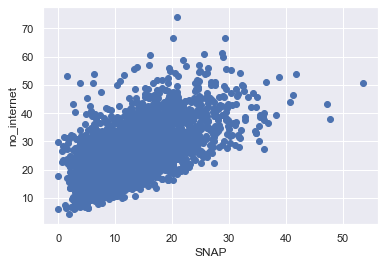

In [11]:
plt.scatter(df["SNAP"], df["no_internet"])
plt.xlabel("SNAP")
plt.ylabel("no_internet")
plt.show()

A similar situation is happening when comparing to population who entered the food supplement program. Looking at all regions where 0-30% of people received SNAP, we'll find some where percentage with no internet at home is very high, and others where isn't. In cases where this situation is extreme, few people will have home connectivity. Rate for no internet at home doesn't tend to be lower than SNAP rate in any case.

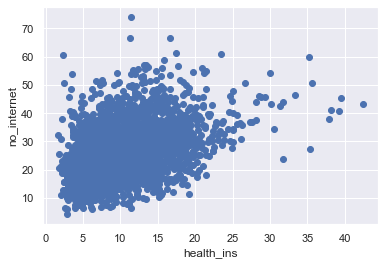

In [12]:
plt.scatter(df["health_ins"], df["no_internet"])
plt.xlabel("health_ins")
plt.ylabel("no_internet")
plt.show()

Reminder that `health_ins` shows the rate of people who does not have health insurance in a specific county. Here we clearly see that no health insurance is a factor for people to not have internet at home; when `health_ins` is between 0-5, we found many counties where the vast majority of people has internet and others where this is not that clear; we even see cases where, with around 2.5% of people without health insurance, 40% or even higher of people has internet at home. The rate for people without health insurance doesn't tend to be higher thant 20%; when it is, a variable portion of population doesn't have internet at home anyway.

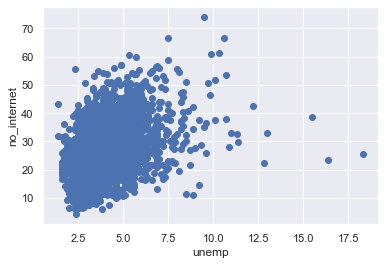

In [13]:
plt.scatter(df["unemp"], df["no_internet"])
plt.xlabel("unemp")
plt.ylabel("no_internet")
plt.show()

The situation for the unemployment rate is exaggerated even more compared to the previous graphics, where there are counties with a very low rate (0-10%) that have really high rate for internet at home and others where don't.

Knowing all this, we'll drop the last two variables since we're not confident about their correlation with the target attribute. This will be done in the next section. We should've chosen a higher threshold value, like 0.5, when choosing the attributes to analyze.

# 3. Regression

We analyzed everything now; what about we start with training and testing our data? We'll estimate the no internet at home rate based on other features.

In [14]:
X = df.loc[:,['no_comp','poverty','SNAP']]
Y = df.loc[:,['no_internet']]

X_train, X_test, y_train, y_test = skl_ms.train_test_split(X, Y, test_size=0.3, random_state=42)

**Linear Regression**
(Finds linear relationship between target and other attributes)

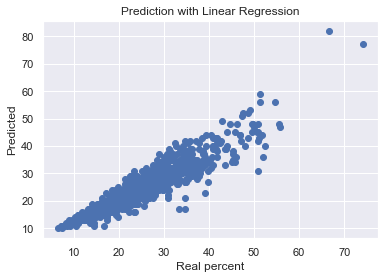

In [15]:
regressor = skl_lm.LinearRegression()
regressor.fit(X_train, y_train)
y_prediction_lr = regressor.predict(X_test)
y_prediction_lr = np.round(y_prediction_lr)
plt.scatter(y_test,y_prediction_lr)
plt.title("Prediction with Linear Regression")
plt.xlabel("Real percent")
plt.ylabel("Predicted")
plt.show()

**Decision Tree Regressor**
(Observes features and trains a model as a tree to predict data)

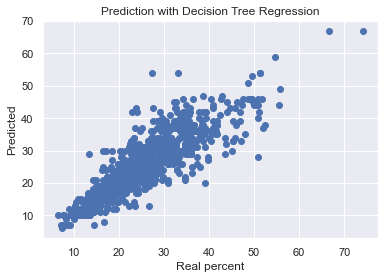

In [16]:
#Fit the model and make prediction
regressor = skl_tree.DecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_prediction_dt = regressor.predict(X_test)
y_prediction_dt = np.round(y_prediction_dt)
plt.scatter(y_test,y_prediction_dt)
plt.title("Prediction with Decision Tree Regression")
plt.xlabel("Real percent")
plt.ylabel("Predicted")
plt.show()

**Random Forest Regressor**
(Fits some decision trees on various sub-samples and uses averaging to improve predictive accuracy and reduce over-fitting)

C:\Users\Jordi\AppData\Local\Temp/ipykernel_22000/4054267925.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


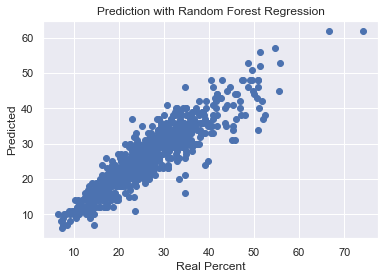

In [17]:
regressor = skl_ensemble.RandomForestRegressor(n_estimators=10,random_state = 42)
regressor.fit(X_train, y_train)
y_prediction_rf = regressor.predict(X_test)
y_prediction_rf = np.round(y_prediction_rf)
plt.scatter(y_test,y_prediction_rf)
plt.title("Prediction with Random Forest Regression")
plt.xlabel("Real Percent")
plt.ylabel("Predicted")
plt.show()

Which model is better? We'll calculate the RSME (Root Mean Square Error) to evaluate the prediction errors.

In [18]:
#Linear Regression
math.sqrt(skl_metrics.mean_squared_error(y_test, y_prediction_lr))

3.5574382168446257

In [19]:
#Decision Tree Regression
math.sqrt(skl_metrics.mean_squared_error(y_test, y_prediction_dt))

4.953991656566787

In [20]:
#Random Forest Regression
math.sqrt(skl_metrics.mean_squared_error(y_test, y_prediction_rf))

3.8121778552423287

It appears to be that the best regressor method is Linear Regression, based on we got the lowest RSME with that method.

# 4. Conclusion

* Our dataset had lots of useless attributes that do not correlate to our target.
* Needing for a food supplemental program, poverty status and no computer at home seem to be the defining factors for not having internet at home.
* Broadband speed, accessibility in its region, not having health insurance or being unemployed do not define whether that person will have internet at home or not.
* The model generated using Linear Regression seems to be the best fitting model to solve this problem through regression.